# Funkcje Pomocnicze do Zadania

Aby wszystkie funkcje zadziałały, notebook powinien być uruchamiany z następującym ułożeniem katalogów:

```
|- helpers.ipynb
|- sampleSubmission.csv
|- train
 |- {unzipped train files and labels}
|- test
 |- {unzipped test files}
```

Należy odkomentować u siebie linijki zapisujące pliki.

In [0]:
!mkdir test

In [0]:
!mkdir train

In [0]:
!conda install -c conda-forge -y librosa

/bin/bash: conda: command not found


In [0]:
import os

import librosa
from scipy import signal
from scipy.io import wavfile
from sklearn.metrics import roc_auc_score
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm, trange

import matplotlib.pyplot as plt
import sklearn.ensemble
import sklearn.metrics

# Wczytywanie Danych

Poniższe funkcje są przykładowymi funkcjami wczytującymi dane. Możliwe, że będą potrzebne modyfikacje reprezentacji i bardziej skomplikowana funkcja tworząca zbiór treningowy. Wczytywanie danych nie jest zaimplementowane optymalnie - między innymi kod wczytuje wielokrotnie ten sam plik. Dla bardziej złożonych reprezentacji możliwe, że trzeba będzie przepisać te funkcje.

In [0]:
def load_mel(file_name, start=0, stop=None, n_mels=60):
    '''Wczytuje mel spektrogram z pliku.
    
    Args:
        file_name (str): Nazwa pliku z nagraniem.
        start (float): Sekunda, w której zaczyna się interesujący fragment.
        stop (float): Sekunda, w której kończy się interesujący fragment.
        n_mels (int): Liczba meli na spektrogramie (wysokość spektrogramu).
    
    Returns:
        ndarray: Spektrogram.
    '''
    samples, sample_rate = librosa.core.load(file_name, sr = None)
    samples = samples[int(start * sample_rate):int(stop * sample_rate) if stop else None]
    spectrogram = librosa.feature.melspectrogram(y = samples, sr = sample_rate,
                                                 n_mels = n_mels, fmin = 4000, fmax = 9500)
    return spectrogram


def load_spec(file_name, start=0, stop=None):
    '''Wczytuje standardowy spektrogram z pliku.
    
    Args:
        file_name (str): Nazwa pliku z nagraniem.
        start (float): Sekunda, w której zaczyna się interesujący fragment.
        stop (float): Sekunda, w której kończy się interesujący fragment.
    
    Returns:
        ndarray: Spektrogram.
    '''
    sample_rate, samples = wavfile.read(file_name)
    samples = samples[int(start * sample_rate):int(stop * sample_rate) if stop else None]
    _, _, spectrogram = signal.spectrogram(samples, sample_rate)
    return spectrogram


def load_test(load_repr=load_mel):
    '''Wczytuje dane testowe.
    
    Args:
        load_repr (function): Funkcja wczytująca pożądaną reprezentację.
    
    Returns:
        ndarray: Tablica z danymi testowymi.
    '''
    with open('sampleSubmission.csv', 'r') as file:
        lines = file.read().split()[1:]
        sample_ids = [line.split(',')[0] for line in lines]
        samples = np.array([s.split('/') for s in sample_ids])
    
    X_test = []
    rec_files = sorted([file_name for file_name in os.listdir('test') 
                        if file_name.endswith('.wav')], key=lambda x: int(x.split('.')[0][3:]))
    for file_name in rec_files:
        recording_id = file_name.split('.')[0][3:]
        time_markers = samples[samples[:, 0] == recording_id, 1].astype(np.int)
        for t in time_markers:
            representation = load_repr(os.path.join('test', file_name), start = t, stop = t + 1)
            X_test.append(representation)
    return np.array(X_test)


def read_labels():
    '''Wczytuje etykiety czasowe z pliku labels.txt w folderze train.
    
    Returns:
        ndarray: Tablica z etykietami czasowymi zawierająca kolumny: nr nagrania, sekunda początku dźwięku, sekunda końca dźwięku.
    '''
    labels = []
    with open(os.path.join('train', 'labels.txt'), 'r') as file:
        text = file.read()
        for line in text.split('\n')[1:]:
            if len(line) > 1:
                rec, start, stop = line.split(',')
                rec, start, stop = int(rec[3:]), float(start), float(stop)
                labels.append([rec, start, stop])
    return np.array(labels)


def check_voices(second, labels, tol=0.):
    '''Sprawdza czy w ramce czasowej [second, second+1] znajduje się głos według etykiet `labels`.
    
    Args:
        second (float): Sekunda nagrania.
        labels (ndarray): Tablica z etykietami, której 2 kolumna oznacza początek, a 3-cia - koniec nagrania.
        tol (float): Tolerancja na brzegach fragmentu. Dźwięk, żeby był uznany, musi się kończyć po czasie `second+tol`
            lub zaczynać przed czasem `second+1-tol`.
    Returns:
        bool: Czy w ramce czasowej jest odgłos ptaka.
    '''
    return (labels[1] >= second and labels[1] < second + 1 - tol) or \
           (labels[2] < second + 1 and labels[2] > second + tol) or \
           (labels[1] < second and labels[2] > second + 1)


def map_seconds_to_y(labels):
    '''Tworzy etykiety dla każdej kolejnej sekundy 10-sekundowego nagrania. -1 oznacza niepewną etykietę (urwane dźwięki na brzegach).
    
    Args:
        labels (ndarray): Tablica z etykietami, której 2 kolumna oznacza początek, a 3-cia - koniec nagrania.
    Returns:
        ndarray: Tablica z binarnymi etykietami dla każdej z 10 sekund z możliwą niepewną etkietą -1.
    '''
    y = [0] * 10
    y_restrictive = [0] * 10
    for s in range(10):
        for l in labels:
            if check_voices(s, l):
                y[s] = 1
            if check_voices(s, l, 0.02):
                y_restrictive[s] = 1
        if y[s] != y_restrictive[s]:
            y[s] = -1
    return y


def load_train(load_repr=load_mel):
    '''Wczytuje dane treningowe.
    
    Args:
        load_repr (function): Funkcja wczytująca pożądaną reprezentację.
    
    Returns:
        (ndarray, ndarray): Tablica z danymi treningowymi, tablica z binarnymi etykietami treningowymi.
    '''
    labels = read_labels()
    X_train, y_train = [], []
    rec_files = [file_name for file_name in os.listdir('train') if file_name.endswith('.wav')]
    for file_name in rec_files:
        recording_id = int(file_name.split('.')[0][3:])
        recording_labels = labels[labels[:, 0] == recording_id]
        y_binary = map_seconds_to_y(recording_labels)
        for i, y in enumerate(y_binary):
            if y != -1:
                try:
                    representation = load_repr(os.path.join('train', file_name), start = i, stop = i + 1)
                    X_train.append(representation)
                    y_train.append(y)
                except ValueError:
                    print('Error reading file', file_name)
                except TypeError:
                    print('Unsupported type', file_name)
    return np.array(X_train), np.array(y_train)

# Zapisywanie Wczytanej Reprezentacji

Ponieważ tworzenie reprezentacji może zabierać sporo czasu (szczególnie w tak naiwnej implementacji jak powyższa), warto zapisać wczytane dane do plików.

In [0]:
# Poniższa linijka ustawia folder główny
# os.chdir('../input/')

X_test = load_test()
# np.save(os.path.join('test', 'tmp_X_test'), X_test)

X, y = load_train()
# np.save(os.path.join('train', 'tmp_X_train'), X)
# np.save(os.path.join('train', 'tmp_y_train'), y)

# Model i Trenowanie

Poniższy przykład używa poprawnych metryk i zapisuje parametry modelu.

In [0]:
class Detector(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        self.linear = torch.nn.Linear(60 * 87, 2)
    
    def forward(self, x):
        out = torch.flatten(x, start_dim = 1)
        out = self.linear(out)
        return out
    
clf = Detector()

In [0]:
class BaseBlock(torch.nn.Module):
    
    def __init__(self, in_channels, out_channels, hidden_channels=None):
        super(BaseBlock, self).__init__()
        if not hidden_channels:
            hidden_channels = out_channels
            
        # konwolucja zawiera padding=1, aby nie zmniejszać rozmiaru obrazu
        self.conv1 = torch.nn.Conv2d(in_channels, hidden_channels, kernel_size=3, padding=1)
        # istnieje wersja batch normalization dla obrazów - statystyki dla filtrów
        self.batch_norm1 = torch.nn.BatchNorm2d(hidden_channels)
        # nieliniowość ReLU
        self.relu1 = torch.nn.ReLU()
        
        # drugi raz te same warstwy
        self.conv2 = torch.nn.Conv2d(hidden_channels, out_channels, kernel_size=3, padding=1)
        self.batch_norm2 = torch.nn.BatchNorm2d(out_channels)
        self.relu2 = torch.nn.ReLU()
    
    def forward(self, x):
        out = self.relu1(self.batch_norm1(self.conv1(x)))
        out = self.relu2(self.batch_norm2(self.conv2(out)))
        return out

In [0]:
class Detector2(torch.nn.Module):
    
    def __init__(self, block):
        super().__init__()
        
        # wstępna warstwa konwolucyjna + ReLU
        self.conv = torch.nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.relu = torch.nn.ReLU()
        
        # (mikroarchitektura + max pooling) x 2
        self.block1 = block(16, 32)
        self.pool1 = torch.nn.MaxPool2d(2)
        self.block2 = block(32, 32)
        self.pool2 = torch.nn.MaxPool2d(2)
        
        # warstwa w pełni połączona po "rozprostowaniu" obrazu do postaci wektora
        self.dense = torch.nn.Linear(10080, 2)
    
    def forward(self, x):
#         out = torch.flatten(x, start_dim = 1)
        x = x[:, None, :, :]
        out = self.relu(self.conv(x))
        out = self.block1(out)
        out = self.pool1(out)
        out = self.block2(out)
        out = self.pool2(out)
        out = out.view(out.size(0), -1)
        return self.dense(out)

In [0]:
class Linear(torch.nn.Module):
  
    def __init__(self):
        super().__init__()
        
        self.lin = torch.nn.Linear(60 * 87, 512)
        self.relu = torch.nn.ReLU()
        
        self.lin2 = torch.nn.Linear(512, 256)
        self.relu = torch.nn.ReLU()
        
        self.lin3 = torch.nn.Linear(256, 128)
        self.relu = torch.nn.ReLU()

        self.lin4 = torch.nn.Linear(128, 64)
        self.relu = torch.nn.ReLU()

        self.lin5 = torch.nn.Linear(64, 32)
        self.relu = torch.nn.ReLU()
        
        self.lin6 = torch.nn.Linear(32, 2)
        self.softmax = torch.nn.Softmax(dim=0)
    
    def forward(self, x):
        x = torch.flatten(x, start_dim = 1)
        x = self.relu(self.lin(x))
        x = self.relu(self.lin2(x))
        x = self.relu(self.lin3(x))
        x = self.relu(self.lin4(x))
        x = self.relu(self.lin5(x))
        return self.softmax(self.lin6(x))

In [0]:
# clf = Detector2(BaseBlock)
# clf = Linear()
clf = Detector()

trainable_params = sum(p.numel() for p in clf.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params}")

In [0]:
# Dzielenie zbioru danych na treningowy i walidacyjny
split_point = int(len(X) * 0.8)

X_train = torch.Tensor(X[:split_point])
y_train = torch.LongTensor(y[:split_point])

X_valid = torch.Tensor(X[split_point:])
y_valid = torch.LongTensor(y[split_point:])

batch_size = 64

dataset = TensorDataset(X_train, y_train)
data_loader = DataLoader(dataset, batch_size = batch_size, shuffle = True)

valid_dataset = TensorDataset(X_valid, y_valid)
valid_data_loader = DataLoader(valid_dataset, batch_size = batch_size)

In [0]:
mean = np.mean(np.asarray(X_train), axis = (0, 1, 2))
std = np.std(np.asarray(X_train), axis = (0, 1, 2))
X_train = (X_train - mean) / (std + 1e-8)
X_valid = (X_valid - mean) / (std + 1e-8)
X_test = (X_test - mean) / (std + 1e-8)

In [0]:
X_train.shape

torch.Size([2871, 60, 87])

In [0]:
X_train_good = X_train[y_train == 1]
X_train_bad = X_train[y_train == 0]

In [0]:
# import cv2

# d = X_train_good

# kernel = np.ones((3,3),np.uint8)
# eroded = cv2.erode(np.asarray(d[0]),kernel,iterations = 1)
# dilated = cv2.dilate(np.asarray(d[0]), kernel, iterations=1)

# plt.imshow(d[0], cmap='hot', interpolation='None')
# plt.colorbar()
# plt.show()

# plt.imshow(eroded, cmap='hot', interpolation='None')
# plt.colorbar()
# plt.show()

# plt.imshow(dilated, cmap='hot', interpolation='None')
# plt.colorbar()
# plt.show()

tensor(0)


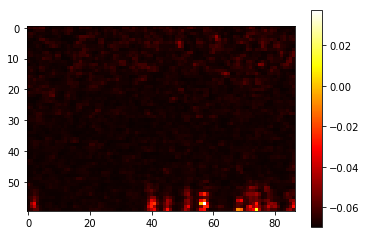

In [0]:
from matplotlib.colors import LogNorm
INDEX_MIN = 0
INDEX_MAX = 1
BIRD = 0
X_plot = X_train[y_train == BIRD]
y_plot = y_train[y_train == BIRD]
for i in range (INDEX_MIN, INDEX_MAX):
  print(y_plot[i])
  plt.imshow(X_plot[i], cmap='hot', interpolation='None')
  plt.colorbar()
  plt.show()

In [0]:
# rf = sklearn.ensemble.RandomForestClassifier()
# rf.fit(X_train.view(2871, 60*87), y_train)

In [0]:
# Ustawienie kosztu i optimizera
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(clf.parameters())

# Pętla uczenia
best_preds, best_score = None, 0.
losses, scores = [], []
for epoch in trange(500):
    running_loss = 0
    clf.train()
    for X, y in data_loader:
        optimizer.zero_grad()

        outputs = clf(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    losses.append(running_loss)
    
    clf.eval()
    preds = []
    for X, _ in valid_data_loader:
        out = clf(X)
        preds.append(torch.softmax(out, dim = 1)[:, 1].detach().numpy())
    preds = np.concatenate(preds, axis = 0)
    
    # Metryką testującą jest ROC AUC
    score = roc_auc_score(y_valid.numpy(), preds)
    scores.append(score)
    if score > best_score:
        best_score = score
        best_preds = preds
        np.save('tmp_preds', best_preds)
        
        # Model dający najlepszy wynik powinien być zapisany
        torch.save(clf.state_dict(), 'tmp_model.pt')
    print(score)

In [0]:
import matplotlib.pyplot as plt

%matplotlib inline

# Rysowanie lossu i AUC
plt.plot(scores)
plt.show()

plt.plot(losses)
plt.show()

# Zapis Predykcji

In [0]:
def save_predictions(preds):
    '''Zapisuje predykcje do pliku zgodnego z formatem odpowiedzi.
    
    Args:
        preds (list): Lista predykcji (prawdopodobieństw).
    '''
    with open('sampleSubmission.csv', 'r') as file:
        submission_text = file.read().split()
        header = submission_text[0]
        lines = submission_text[1:]

    output_lines = [header]
    for pred, line in zip(preds, lines):
        output_lines.append("{},{}".format(line.split(',')[0], pred))
    
    with open('mySubmission.csv', 'w') as file:
        file.write('\n'.join(output_lines) + '\n')

In [0]:
# Wczytanie najlepszego modelu
# clf.load_state_dict('tmp_model.pt')

# Tworzenie data loadera testowego
X_test_tensor = torch.Tensor(X_test)

test_dataset = TensorDataset(X_test_tensor)
test_data_loader = DataLoader(test_dataset, batch_size = batch_size)

# Ewaluacja modelu na danych testowych
clf.eval()
preds = []
for X in test_data_loader:
    out = clf(X[0])
    preds.append(torch.softmax(out, dim = 1)[:, 1].detach().numpy())
preds = np.concatenate(preds, axis = 0)

# Zapisanie predykcji do poprawnego formatu
save_predictions(preds)

In [0]:
# preds_valid = rf.predict_proba(X_valid.view(X_valid.shape[0], 60*87))[:,1]
# print(preds_valid.shape)
# auc_valid = sklearn.metrics.roc_auc_score(y_valid, preds_valid)
# print(auc_valid)

In [0]:
preds = rf.predict_proba(torch.Tensor(X_test).view(924, 60*87))[:, 1]
save_predictions(preds)